In [1]:
%matplotlib inline
import zounds
from IPython.display import Audio, display
from matplotlib import pyplot as plt

samplerate = zounds.SR11025()
BaseModel = zounds.resampled(resample_to=samplerate, store_resampled=True)
sample_size = 8192
segment_duration = samplerate.frequency * sample_size

wscheme = zounds.SampleRate(
    frequency=segment_duration, duration=segment_duration)

@zounds.simple_in_memory_settings
class Sound(BaseModel):
    windowed = zounds.ArrayWithUnitsFeature(
        zounds.SlidingWindow,
        wscheme=wscheme,
        wfunc=None,
        needs=BaseModel.resampled)

_id = Sound.process(meta='https://archive.org/download/LucaBrasi2/02-Kevin_Gates-I_Don_t_Get_Tired_IDGT_Feat_August_Alsina_Prod_By_Nic_Nac_Mark_Kragen.ogg')
snd = Sound(_id)

/home/user/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


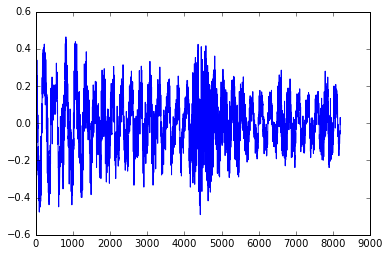

In [2]:
index = 100
plt.plot(snd.windowed[index])
plt.show()

Audio(snd.windowed[index], rate=int(samplerate))

[0, 0.5442670537010159, 0.5624092888243831, 0.5805515239477503, 1]


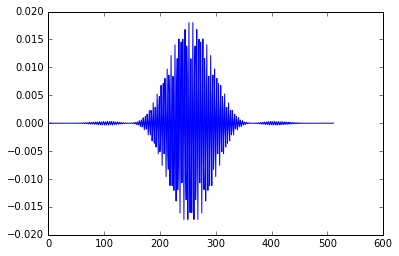

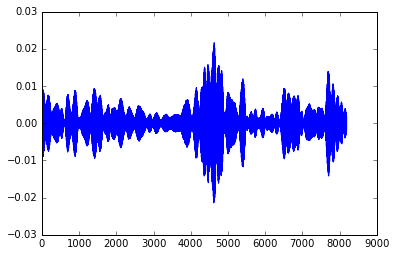

In [3]:
from scipy.signal import butter, lfilter, convolve, firwin, gaussian, firwin2

freq = [0, 3000. / samplerate.nyquist, 3100. / samplerate.nyquist, 3200. / samplerate.nyquist, 1]
print freq
gain = [0, 0.0, 1, 0.00,  0]
win = firwin2(512, freq, gain)

plt.plot(win)
plt.show()


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)    
    #y = lfilter(b, a, data)
    y = convolve(data, win, mode='same')
    return y

filtered = butter_bandpass_filter(snd.windowed[index], 3000, 3100, int(samplerate))
plt.plot(filtered)
plt.show()
Audio(filtered, rate=int(samplerate))

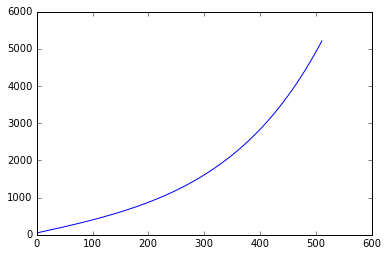

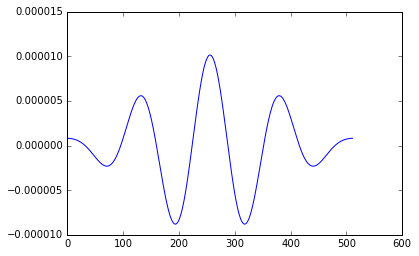

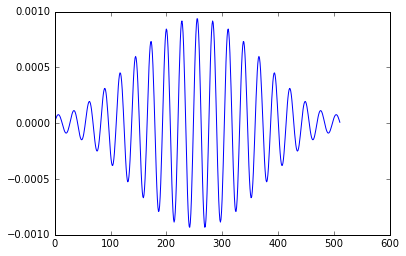

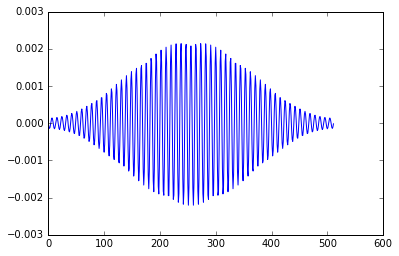

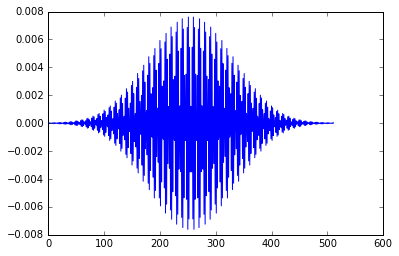

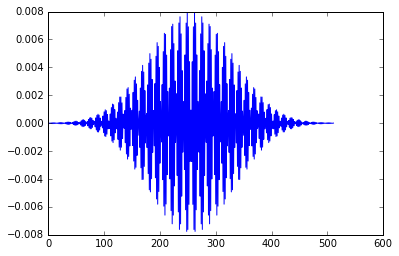

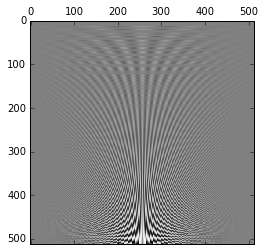

In [34]:
from scipy.signal import gaussian
from matplotlib import pyplot as plt
import numpy as np


scale = zounds.BarkScale(
    zounds.FrequencyBand(50, samplerate.nyquist - 300),
    n_bands=512)
scale.ensure_overlap_ratio(0.5)

basis_size = 512
lap = 1

basis = zounds.fir_filter_bank(scale, basis_size, samplerate, gaussian(100, 3))

plt.plot([band.center_frequency for band in scale])
plt.show()

plt.plot(basis[10])
plt.show()

plt.plot(basis[100])
plt.show()

plt.plot(basis[256])
plt.show()

plt.plot(basis[-10])
plt.show()

plt.plot(basis[-5])
plt.show()

plt.matshow(np.array(basis), cmap='gray')

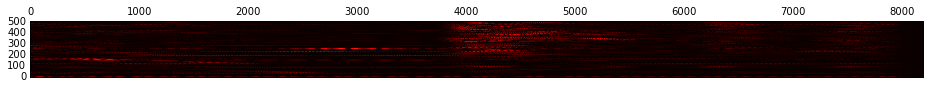

In [35]:
_, sw = snd.windowed[index].sliding_window_with_leftovers(
    windowsize=basis_size,
    stepsize=1,
    dopad=True)

spec = np.dot(sw, basis.T)

plt.matshow(np.abs(spec.T), origin='lower', cmap='hot')
plt.show()

In [36]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F

samples = Variable(torch.from_numpy(snd.windowed[index]).float())
weights = Variable(torch.from_numpy(basis).float())
samples = samples.view(-1, 1, sample_size).contiguous()

# out channels x in channels x kernel width 
weights = weights.view(len(scale), 1, basis_size).contiguous()

In [ ]:
features = F.conv1d(samples, weights, stride=lap, padding=basis_size)

np_features = features.data.cpu().numpy().squeeze()
plt.matshow(np.abs(np_features), origin='lower', cmap='hot')
plt.show()

# half-wave rectification
features = F.relu(features)

np_features = features.data.cpu().numpy().squeeze()
plt.matshow(np.abs(np_features), origin='lower', cmap='hot')
plt.show()

# log magnitude
features = torch.log(features * 10000 + 1)

np_features = features.data.cpu().numpy().squeeze()
plt.matshow(np.abs(np_features), origin='lower', cmap='hot')
plt.show()

# gradient/sharpening
features = features.view(1, 1, 512, -1)
means = F.avg_pool2d(features, (5, 5), stride=(1, 1), padding=(2, 2))
maxes = F.max_pool2d(features, (5, 5), stride=(1, 1), padding=(2, 2))
salience = (means / (maxes + 1e-8))

# print features.shape, salience.shape
# features = features * salience
features = means * maxes
features = features.view(1, 512, -1)


plt.matshow(means.data.cpu().numpy().squeeze(), origin='lower', cmap='hot')
plt.show()
plt.matshow(maxes.data.cpu().numpy().squeeze(), origin='lower', cmap='hot')
plt.show()
plt.matshow(salience.data.cpu().numpy().squeeze(), origin='lower', cmap='hot')
plt.show()


np_features = features.data.cpu().numpy().squeeze()
plt.matshow(np.abs(np_features), origin='lower', cmap='hot')
plt.show()

# kernel = np.array([
#         [0, -1, 0],
#         [-1, 0, 1],
#         [0,  1, 0],
#     ])
# kernel = Variable(torch.from_numpy(kernel).float()).view(1, 1, 3, 3)
# features = F.conv2d(features, kernel, stride=1, padding=(1, 1))
# features = features.view(1, 512, -1)

recon = F.conv_transpose1d(features, weights, stride=lap)
np_recon = recon.data.cpu().numpy().squeeze()
print np_recon.size

plt.plot(snd.windowed[index])
plt.show()

plt.plot(np_recon)
plt.show()

Audio(np_recon, rate=int(samplerate))